In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from processing_utils import *

### Data Pipeline Application

In [2]:
raw_dataset = pd.read_csv('./dataset/data.csv')
print(raw_dataset.head())
pruned_dataset = prune_dataset_lines(
    raw_dataset, remove_nan_lines=False, remove_nan_cols=True)
print("Raw dataset shape =", raw_dataset.shape,
      " Pruned dataset shape =", pruned_dataset.shape)

encoded_pruned_data = encode_smiles_column_of(
    pruned_dataset, 'count_encoding')  # change to one_hot_encoding here
print("Encoded dataset shape =", encoded_pruned_data.shape)

X_train, y_train, X_val, y_val, X_test, y_test = return_required_data(
    encoded_pruned_data,
    ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    ['Zero_point_energy_(kcal/mol@0K)', 'Enthalpy_(kcal/mol@298K)', 'Gibbs_energy_(kcal/mol@298K)'],
    normalize=True
)

print("X_train shape =", X_train.shape)
print("y_train shape =", y_train.shape)
print("X_val shape =", X_val.shape)
print("y_val shape =", y_val.shape)
print("X_test shape =", X_test.shape)
print("y_test shape =", y_test.shape)


                 Chiral_Molecular_SMILES  Energy_(kcal/mol)  \
0                 Fc1ccc(cc1)c1cn[nH]c1N       -51177.14356   
1                 Fc1ccc(cc1)c1cn[nH]c1N       -51177.14356   
2   O=C(c1ccccc1)O[C@H]1c2ccccc2C(=O)N1C       -73542.31526   
3   O=C(c1ccccc1)O[C@H]1c2ccccc2C(=O)N1C       -73542.31444   
4  O=C(c1ccccc1)O[C@@H]1c2ccccc2C(=O)N1C       -73542.31445   

   Zero_point_energy_(kcal/mol@0K)  Enthalpy_(kcal/mol@298K)  \
0                        93.711236                101.010221   
1                        93.716622                101.010607   
2                       150.283189                161.552872   
3                       150.296914                161.555511   
4                       150.299719                161.554575   

   Gibbs_energy_(kcal/mol@298K)  Energy DG:kcal/mol)       PMI1         PMI2  \
0                     72.646019         -51104.49754  15.116918  1138.689784   
1                     72.676293         -51104.46727  55.760384  2320.928165

### Linear Regression

In [3]:
from sklearn.linear_model import LinearRegression

X_train, y_train, X_test, y_test = return_required_data(
    encoded_pruned_data, 
    ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'], 
    ['Zero_point_energy_(kcal/mol@0K)', 'Enthalpy_(kcal/mol@298K)', 'Gibbs_energy_(kcal/mol@298K)'],
    normalize=True,
    normalize_targets=True,
    validation=False
)

LR_Energy_ = LinearRegression()
LR_Energy_ = LR_Energy_.fit(X_train, y_train[:, 0])

LR_EnergyDG = LinearRegression()
LR_EnergyDG = LR_EnergyDG.fit(X_train, y_train[:, 1])

print("mse(y_train_Energy_, y_pred_train_Energy_) =", mean_squared_error(y_train[:, 0], LR_Energy_.predict(X_train)))
print("mse(y_test_Energy_, y_pred_test_Energy_) =", mean_squared_error(y_test[:, 0], LR_Energy_.predict(X_test)))
print("==================================")

print("Test prediction mse =", mean_squared_error(y_test[:5, 0], LR_Energy_.predict(X_test[:5, :])))
print("Actual Real target values : \n", y_test[:5, 0])
print("Sample predicted vector : \n", LR_Energy_.predict(X_test[:5, :]))
print("==================================")

print("mse(y_train_EnergyDG, y_pred_train_EnergyDG) =", mean_squared_error(y_train[:, 1], LR_EnergyDG.predict(X_train)))
print("mse(y_test_EnergyDG, y_pred_test_EnergyDG) =", mean_squared_error(y_test[:, 1], LR_EnergyDG.predict(X_test)))
print("==================================")

print("Test prediction mse =", mean_squared_error(y_test[:5, 1], LR_EnergyDG.predict(X_test[:5, :])))
print("Actual Real target values : \n", y_test[:5, 1])
print("Sample predicted vector : \n", LR_EnergyDG.predict(X_test[:5, :]))

mse(y_train_Energy_, y_pred_train_Energy_) = 2.7631559981928316e-06
mse(y_test_Energy_, y_pred_test_Energy_) = 2.6817113777943324e-06
Test prediction mse = 3.624802632677278e-06
Actual Real target values : 
 [ 0.8487947   0.11726522 -1.48409101  0.82605651  1.33467482]
Sample predicted vector : 
 [ 0.85136992  0.11963949 -1.48308367  0.8276357   1.33314299]
mse(y_train_EnergyDG, y_pred_train_EnergyDG) = 2.772086377893522e-06
mse(y_test_EnergyDG, y_pred_test_EnergyDG) = 2.690378551976572e-06
Test prediction mse = 3.6365178188665374e-06
Actual Real target values : 
 [ 0.84908891  0.11520764 -1.47770517  0.82503716  1.33511329]
Sample predicted vector : 
 [ 0.85166829  0.11758574 -1.47669621  0.8266189   1.33357898]


In [4]:
print("Cross validation error LR_Energy_ =", cross_validation_of( LR_Energy_, X_train, y_train))
print("Cross Validation of EnergyGD =", cross_validation_of( LR_EnergyDG, X_train, y_train))

Cross validation error LR_Energy_ = 2.790929072119353e-06
Cross Validation of EnergyGD = 2.790929072119353e-06


#### Performances wrt. training dataset size

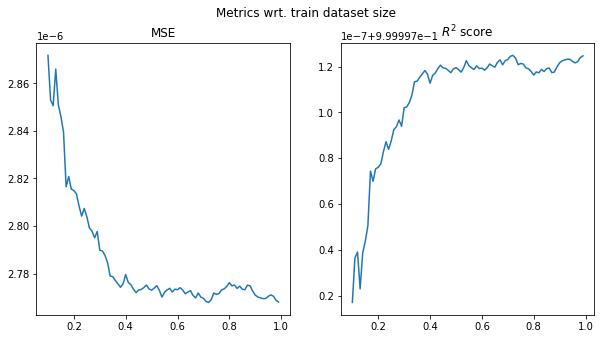

In [6]:
from utils import split_array
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import random
mses = []
r2_scores = []
percentages = np.arange(0.1, 1, 0.01)
# seed = random.randint(0, 10000)
seed = 7732
for p in percentages:
    # print(f"p={p}, seed={seed}")
    X_train, y_train, X_test, y_test = return_required_data(
        encoded_pruned_data,
        ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
        ['Zero_point_energy_(kcal/mol@0K)', 'Enthalpy_(kcal/mol@298K)',
         'Gibbs_energy_(kcal/mol@298K)'],
        normalize=True,  # DO NOT CHANGE THAT!
        validation=False,
        seed=seed
    )
    X_tr, _ = split_array(X_train, p)
    y_tr, _ = split_array(y_train, p)
    lr = LinearRegression()
    lr = lr.fit(X_tr, y_tr)
    y_pred = lr.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Metrics wrt. train dataset size')
ax1.set_title('MSE')
ax1.plot(percentages, mses)
ax2.set_title('$R^2$ score')
ax2.plot(percentages, r2_scores)
plt.show()


#### Performances wrt. added noise

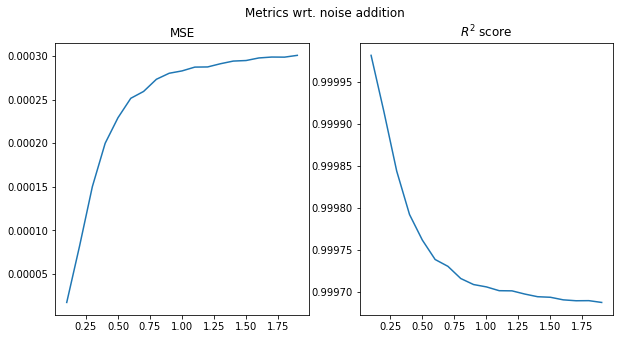

In [7]:

mses = []
r2_scores = []
scale_factors = np.arange(0.1, 2, 0.1)
for scale_factor in scale_factors:
    X_train, y_train, X_test, y_test = return_required_data(
        encoded_pruned_data,
        ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
        ['Zero_point_energy_(kcal/mol@0K)', 'Enthalpy_(kcal/mol@298K)',
         'Gibbs_energy_(kcal/mol@298K)'],
        normalize=True,
        validation=False,
        seed=7732
    )
    for column in X_train.T[:3]:
        column += np.random.normal(column.mean(),
                                   column.std() * scale_factor, column.shape)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Metrics wrt. noise addition')
ax1.set_title('MSE')
ax1.plot(scale_factors, mses)
ax2.set_title('$R^2$ score')
ax2.plot(scale_factors, r2_scores)
plt.show()
